## import

In [4]:
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd
from matplotlib.ticker import MultipleLocator, FuncFormatter


In [5]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

## plot pressure gauge data

In [6]:
from pathlib import Path

# file_path = Path.cwd() / "1" / "1.xlsx"  # 获取当前工作目录的目录下的 "1/1.xlsx" 文件路径
# file_path = Path.cwd().parent / "1" / "1.xlsx" # 获取当前工作目录的父目录下的 "1/1.xlsx" 文件路径


example_path = Path.cwd() / "model" / "Zgabay_Evo5.xlsx"
try:
    xls = pd.ExcelFile(example_path, engine="openpyxl")
    print("Sheets:", xls.sheet_names)
except FileNotFoundError:
    print(f"找不到文件: {example_path}")
except Exception as e:
    print("读取 Excel 时出错:", e)

Sheets: ['Information', 'Signal Summary', 'Grid', 'pressure_drop', 'pressure_drop (2)']


In [7]:
# 读取指定 sheet（'pressure_drop (2)'），打印标题和列名，并将每列数据导出为 notebook 变量（变量名由列名简化而来）
sheet_name = "pressure_drop (2)"

try:
    # 读取为带列名的 DataFrame
    sheet_df = xls.parse(sheet_name)
except Exception as e:
    raise RuntimeError(f"无法读取 sheet '{sheet_name}': {e}")

# 尝试从最上方单元格判断是否存在显式的标题（例如表格上方有单独的一行标题）
_rows = xls.parse(sheet_name, header=None)
top_cell = _rows.iloc[0, 0] if not _rows.empty else None
if isinstance(top_cell, str) and top_cell.strip() and top_cell.strip() not in list(sheet_df.columns):
    sheet_title = top_cell.strip()
else:
    sheet_title = sheet_name

print("Sheet title:", sheet_title)
print("Columns:", list(sheet_df.columns))

# 将每一列导出为变量，变量名由列名规范化得到（非字母数字替换为下划线，若以数字开头则加前缀下划线）
created_vars = {}
for col in sheet_df.columns:
    # 跳过完全空的列名
    if col is None:
        continue
    name = str(col).strip()
    if not name:
        continue
    # 规范化为合法的 Python 标识符
    var_name = ''.join(ch if (ch.isalnum() or ch == "_") else "_" for ch in name)
    if var_name and var_name[0].isdigit():
        var_name = "_" + var_name
    if not var_name:
        var_name = "col"
    base = var_name
    i = 1
    # 避免覆盖已有全局变量
    while var_name in globals():
        var_name = f"{base}_{i}"
        i += 1
    # 将该列作为 pandas Series 赋值到全局命名空间
    globals()[var_name] = sheet_df[col]
    created_vars[var_name] = col

print(f"Created {len(created_vars)} variables from sheet '{sheet_name}':")
for vn, col in created_vars.items():
    print(f"  {vn}  <- column '{col}' (length={len(globals()[vn])})")

# 显示前几行作为校验
print("\nPreview (first 5 rows) of the dataframe:")
print(sheet_df.head())

Sheet title: pressure_drop (2)
Columns: ['Date-Time', 13004, 13713, 14851, 15321, 16598, 17423, 'delta_time']
Created 8 variables from sheet 'pressure_drop (2)':
  Date_Time  <- column 'Date-Time' (length=52988)
  _13004  <- column '13004' (length=52988)
  _13713  <- column '13713' (length=52988)
  _14851  <- column '14851' (length=52988)
  _15321  <- column '15321' (length=52988)
  _16598  <- column '16598' (length=52988)
  _17423  <- column '17423' (length=52988)
  delta_time  <- column 'delta_time' (length=52988)

Preview (first 5 rows) of the dataframe:
            Date-Time     13004    13713     14851     15321     16598  \
0 2022-03-15 09:00:00  0.000000  0.00000  0.000000  0.000000  0.000000   
1 2022-03-15 09:00:10  0.787000 -0.00218  0.000000  0.000000 -0.007625   
2 2022-03-15 09:00:20  0.787000 -0.00218  0.012052  0.067000 -0.012000   
3 2022-03-15 09:00:30  1.058329  0.00482  0.019000  0.067000 -0.012000   
4 2022-03-15 09:00:40  1.216000  0.00482  0.006966  0.127169 -0.00

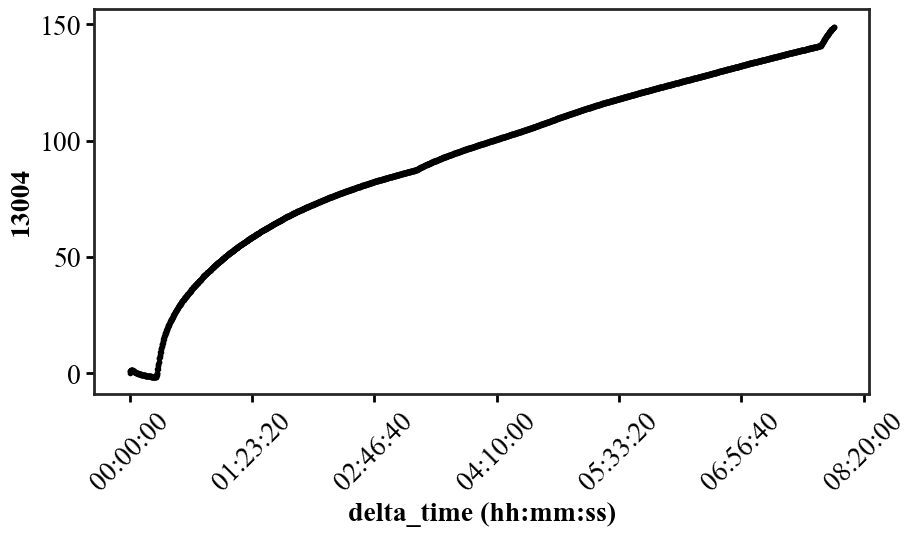

In [8]:
from matplotlib.ticker import FuncFormatter

# 过滤出 Date-Time 在 2022-03-15 09:00:00 起 8 小时内的数据，并以 delta_time 为 x 轴（显示为 hh:mm:ss），13004 为 y 轴绘图
start = pd.Timestamp("2022-03-15 09:00:00")
end = start + pd.Timedelta(hours=8)

mask = (sheet_df["Date-Time"] >= start) & (sheet_df["Date-Time"] <= end)
df_plot = sheet_df.loc[mask].copy()

if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 使用 Date-Time - start 作为 x（Timedelta），并把 x 转为秒用于绘图，x 轴标签显示为 hh:mm:ss
    x_td = df_plot["Date-Time"] - start
    x_sec = x_td.dt.total_seconds()
    y = df_plot[13004]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_sec, y, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("13004")

    def _sec_to_hms(x, pos=None):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"
    ax.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))

    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

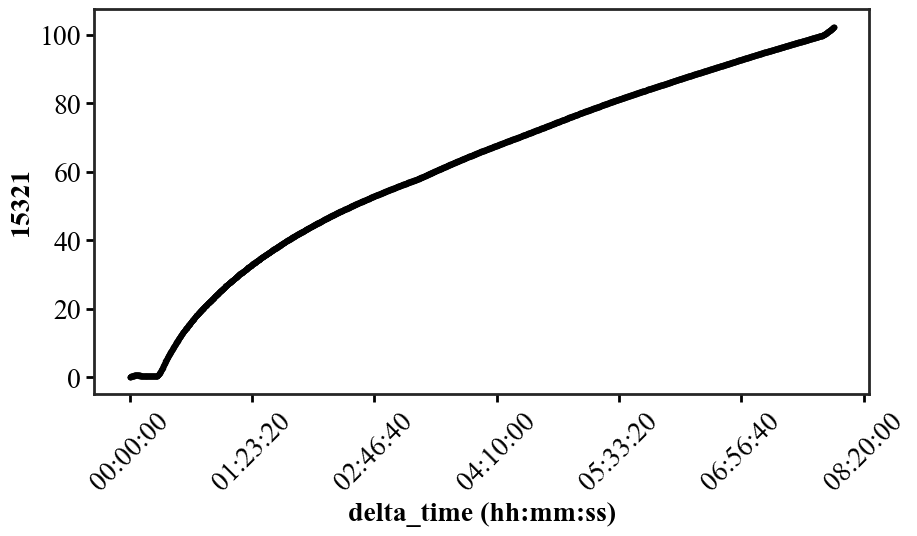

In [9]:
# 以 delta_time 为 x（显示为 hh:mm:ss），15321 为 y 绘图（时间范围已在 df_plot 中筛选）
if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 优先复用已计算的 x_sec；若不存在则由 delta_time 解析得到秒数
    x = x_sec if "x_sec" in globals() else pd.to_timedelta(df_plot["delta_time"].astype(str)).dt.total_seconds()
    y_15321 = df_plot[15321]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y_15321, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("15321")
    # ax.set_title("delta_time ~ 15321 (2022-03-15 09:00:00 起 8 小时)")

    # 复用已有的格式化函数；若不存在则定义一个
    try:
        fmt = FuncFormatter(_sec_to_hms)
    except NameError:
        def _sec_to_hms(val, pos=None):
            h = int(val // 3600)
            m = int((val % 3600) // 60)
            s = int(val % 60)
            return f"{h:02d}:{m:02d}:{s:02d}"
        fmt = FuncFormatter(_sec_to_hms)

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

## curves fitting (fitting perm and delta p together)

### pressure fitting

Best-fit k   = 4.965e+01 mD
Best-fit A   = 165.510 psi   (≈ p0 - p1)
Best-fit eta = 3.378e+00 ft^2/s
R^2          = 0.9838


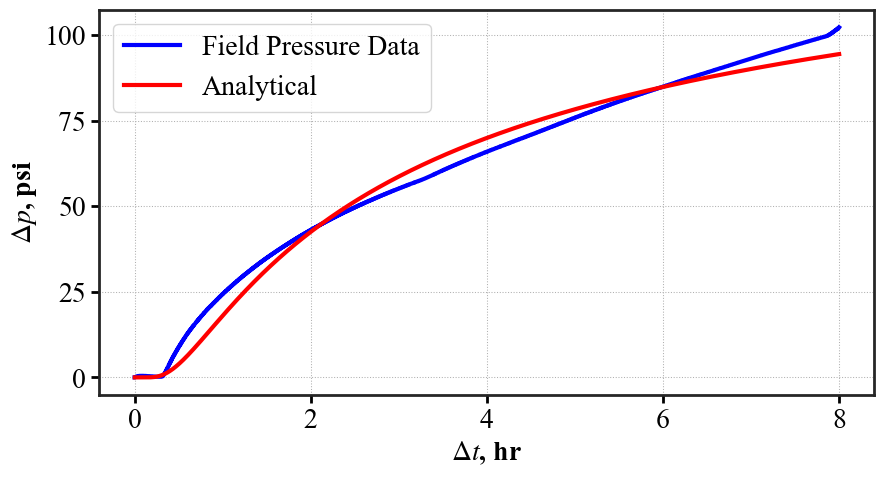

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- erfc ----------
try:
    from numpy import erfc as _erfc
except Exception:
    import math
    _erfc = np.vectorize(lambda z: 1.0 - math.erf(z))

# ---------- 单位换算与模型 ----------
def diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi):
    """k[mD], mu[cP], phi[-], ct[1/psi]  -> η[ft^2/s]"""
    return ((9.869233e-16)/(1e-3)*6894.757*3.2808**2) * k_mD / (mu_cP * phi * ct_per_psi)

def f_kernel(t_sec, k_mD, x_ft, mu_cP, phi, ct_per_psi):
    """f_k(t) = erfc( x / (2*sqrt(η t)) )"""
    t = np.asarray(t_sec, float)
    t = np.clip(t, 1e-9, None)
    eta = diffusivity_ft2_per_s(k_mD, mu_cP, phi, ct_per_psi)
    z = x_ft / (2.0*np.sqrt(eta*t))
    return _erfc(z)

def A_opt_given_k(t_sec, y_psi, k_mD, x_ft, mu_cP, phi, ct_per_psi, nonneg=True):
    """对给定 k 的最优 A（最小二乘解析解），可选非负约束"""
    f = f_kernel(t_sec, k_mD, x_ft, mu_cP, phi, ct_per_psi)
    num = np.nansum(f*y_psi)
    den = np.nansum(f*f)
    if den <= 0:
        return 0.0
    A = num/den
    if nonneg:
        A = max(0.0, A)
    return float(A)

def sse_of_k_log10(logk, t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi):
    k = 10.0**logk
    A = A_opt_given_k(t_sec, y_psi, k, x_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A * f_kernel(t_sec, k, x_ft, mu_cP, phi, ct_per_psi)
    r = y_psi - yhat
    return np.nansum(r*r)

def fit_A_k_dual(t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi,
                 k_bounds=(1e-6, 10.0), return_curve=True):
    """
    同时拟合 A=(p0-p1) 与 k（mD）。
    方法：在 log10(k) 上黄金分割搜索，A 用解析解。
    """
    t = np.asarray(t_sec, float)
    y = np.asarray(y_psi, float)
    m = np.isfinite(t)&np.isfinite(y)&(t>0)
    t, y = t[m], y[m]
    if t.size < 5:
        raise ValueError("有效数据点不足")

    # 先粗网格确定区间
    lo, hi = np.log10(k_bounds[0]), np.log10(k_bounds[1])
    grid = np.linspace(lo, hi, 200)
    sse_vals = np.array([sse_of_k_log10(g, t, y, x_ft, mu_cP, phi, ct_per_psi) for g in grid])
    j = int(np.argmin(sse_vals))
    a = grid[max(0, j-1)]
    b = grid[min(len(grid)-1, j+1)]
    if j == 0: a, b = lo, grid[3]
    if j == len(grid)-1: a, b = grid[-4], hi

    # 黄金分割
    phi_g = (1 + np.sqrt(5)) / 2
    invphi = 1/phi_g
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = sse_of_k_log10(c, t, y, x_ft, mu_cP, phi, ct_per_psi)
    fd = sse_of_k_log10(d, t, y, x_ft, mu_cP, phi, ct_per_psi)
    for _ in range(80):
        if (b - a) < 1e-6:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a)
            fc = sse_of_k_log10(c, t, y, x_ft, mu_cP, phi, ct_per_psi)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a)
            fd = sse_of_k_log10(d, t, y, x_ft, mu_cP, phi, ct_per_psi)

    logk_best = (a+b)/2.0
    k_best = 10.0**logk_best
    A_best = A_opt_given_k(t, y, k_best, x_ft, mu_cP, phi, ct_per_psi, nonneg=True)
    yhat = A_best * f_kernel(t, k_best, x_ft, mu_cP, phi, ct_per_psi)

    ss_res = np.nansum((y - yhat)**2)
    ss_tot = np.nansum((y - np.nanmean(y))**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    if return_curve:
        return k_best, A_best, R2, (t, yhat)
    else:
        return k_best, A_best, R2

# ===================== 使用示例（与你的数据衔接） =====================
GAUGE_COL = 15321#13004
t_sec = (df_plot["Date-Time"] - df_plot["Date-Time"].iloc[0]).dt.total_seconds().to_numpy()
y_psi = df_plot[GAUGE_COL].to_numpy()

# —— 在这里填入物性与几何（单位务必与注释一致）——

x_ft       = 250       # 计量点到边界/裂缝面的法向距离 [ft]
mu_cP      = 0.185        # 黏度 [cP]
phi        = 0.3       # 孔隙度 [-]
ct_per_psi = 1.94e-5     # 体积压缩系数 [1/psi]



# 拟合（按需要可放宽 k 范围）
k_best_mD, A_best_psi, R2, (t_used, yhat) = fit_A_k_dual(
    t_sec, y_psi, x_ft, mu_cP, phi, ct_per_psi,
    k_bounds=(40, 80.0), return_curve=True
)

eta_best = diffusivity_ft2_per_s(k_best_mD, mu_cP, phi, ct_per_psi)
print(f"Best-fit k   = {k_best_mD:.3e} mD")
print(f"Best-fit A   = {A_best_psi:.3f} psi   (≈ p0 - p1)")
print(f"Best-fit eta = {eta_best:.3e} ft^2/s")
print(f"R^2          = {R2:.4f}")

# 叠加绘图
def _sec_to_hms(x, pos=None):
    h = int(x // 3600); m = int((x % 3600)//60); s = int(x % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t_sec, y_psi, color='blue', lw = 3, label='Field Pressure Data')
ax.plot(t_used, yhat, color='red', lw = 3, label='Analytical')
ax.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))
ax.set_xticks([0, 7200,  14400,  21600, 28800])
ax.set_xticklabels(['0','2','4','6','8'])
ax.yaxis.set_major_locator(MultipleLocator(25))     # 每 2000 ft 一个大刻度


ax.set_xlabel(r'$\Delta t$, hr')
ax.set_ylabel(r'$\Delta p$, psi')
ax.grid(True, which='both', linestyle=':', linewidth=0.75)
ax.legend()

plt.savefig("pressure_strain_matching_gauge4.png", dpi=600,bbox_inches='tight')

plt.show()
# fig.show()


### strain change fitting

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd

from merge_h5_files import merge_preserve_time
import os
import glob





In [3]:
# Read h5 files
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
print(list(f1.keys()))
# 继续进入下一层
data_group = f1['data']
print(data_group)
# print(list(data_group.keys()))
# 继续进入下一层
# data_group2 = data_group['Raw[0]']
# print(list(data_group2.keys()))
# 继续进入下一层
# RawData = data_group2['RawData']
# print(RawData)
# RawDataTime = data_group2['RawDataTime']
# print(RawDataTime)

['data', 'depth', 'stamps', 'stamps_unix']
<HDF5 dataset "data": shape (7008, 57218), type "<f4">


In [19]:
from slippage_clbrt_shift import shift_depth_piecewise, invert_shift_depth_piecewise

gauges = np.array([13004, 15321, 13753.1])
gauge_to_fiber = invert_shift_depth_piecewise(gauges, z0=12000.0, z1=16000.0, s0=145.0, s1=160.0)
print("测点深度 gauges: ", gauges)
print("对应纤维深度 gauge_to_fiber: ", gauge_to_fiber)

测点深度 gauges:  [13004.  15321.  13753.1]
对应纤维深度 gauge_to_fiber:  [12855.79078456 15164.13449564 13602.09215442]


In [45]:
from tomlkit import date


dstrain = (f1['data'])  #（time, depth）
depth = (f1['depth'])
date_str = (f1['stamps'])
date_us = (f1['stamps_unix'])


depth = np.asarray(depth)
dstrain = np.asarray(dstrain)
date_str = np.asarray(date_str)
date_us = np.asarray(date_us)

In [84]:
def nearest_col_indices(depth_1d, targets):
    """
    targets 可以是标量或数组。返回与每个 target 最近的列索引。
    """
    t = np.atleast_1d(targets).astype(float)
    # 计算 |depth - target| 并在列轴上取最小
    idx = np.argmin(np.abs(depth_1d[None, :] - t[:, None]), axis=1)
    return idx

targets = gauge_to_fiber[0]
idx = nearest_col_indices(depth, targets)
depth_near = depth[idx]
err = targets - depth_near

print("targets:    ", targets)
print("idx:        ", idx)
print("depth_near: ", depth_near)
print("error(ft):  ", err)


targets:     12855.790784557908
idx:         [38986]
depth_near:  [12855.825]
error(ft):   [-0.03417969]


In [90]:
cols = dstrain[:, idx]                 # shape = (N_time, len(targets))
length = len(cols)
print(f"读取 {length} 条记录")

读取 7008 条记录


In [92]:
#  你的字符串列是 bytes，需要先解码成 str 再解析为 datetime（naive）
ds = pd.to_datetime(pd.Series(date_str.astype(str)), format='%m/%d/%Y %H:%M:%S.%f')
print(type(ds))
print(ds)

#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2022-03-15 09:00:00")
end   = pd.Timestamp("2022-03-15 17:00:00")

mask = (ds >= start) & (ds <= end)

t_sel    = ds[mask]
# print(mask)
print(t_sel)



<class 'pandas.core.series.Series'>
0      2022-03-14 20:56:49.350706
1      2022-03-14 20:58:13.618471
2      2022-03-14 20:59:38.346233
3      2022-03-14 21:01:02.745833
4      2022-03-14 21:02:27.442383
                  ...            
7003   2022-03-21 18:08:26.564440
7004   2022-03-21 18:09:51.421313
7005   2022-03-21 18:11:16.399100
7006   2022-03-21 18:12:41.365719
7007   2022-03-21 18:14:06.359133
Length: 7008, dtype: datetime64[ns]
514   2022-03-15 09:00:21.241823
515   2022-03-15 09:01:45.657049
516   2022-03-15 09:03:10.603584
517   2022-03-15 09:04:35.487611
518   2022-03-15 09:05:59.871621
                 ...            
850   2022-03-15 16:53:56.435584
851   2022-03-15 16:55:21.194610
852   2022-03-15 16:56:46.078584
853   2022-03-15 16:58:10.837641
854   2022-03-15 16:59:35.315370
Length: 341, dtype: datetime64[ns]


In [ ]:

# ========= 2) 画图对象 =========
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 36,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 30,        # X轴刻度文字
      'ytick.labelsize': 30,        # Y轴刻度文字
      'legend.fontsize': 30,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 3.0,
      } 
# lack of font size
plt.rcParams.update(rc)

fig, ax1 = plt.subplots(figsize=(10, 4.5), dpi=150)

# 第二 y 轴（右）
ax2 = ax1.twinx()
# 第三 y 轴（再往外偏移 60pt）
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 120))  # 关键：把第三轴移到外侧
ax3.set_frame_on(True)
ax3.patch.set_visible(False)  # 不遮挡主绘图区

# ========= 3) 绘制三条曲线 =========
c1, c2, c3 = "#C00000", "blue", "black"

l1, = ax1.plot(t_sel, whp_sel, color=c1, lw=2.25, label="Treating pressure (psi)")
l2, = ax2.plot(t_sel, rate_sel, color=c2, lw=2.25, label="Slurry rate (bbl/min)")
l3, = ax3.plot(t_sel, conc_sel, color=c3, lw=2.25, label="Proppant conc (lbm/gal)")

# ========= 4) 轴与刻度样式 =========
# ---- y 轴颜色统一（标签、刻度、脊线）----
# 左轴（红）
# ax1.set_ylabel("Treating pressure (psi)", color=c1)
ax1.tick_params(axis="y", colors=c1, width=1.2)
ax1.spines["left"].set_color(c1)
ax1.spines["left"].set_linewidth(1.2)
#set y axis limits
# ax1.set_ylim(-1000, 18000)
# #set y axis ticks
ax1.set_yticks([0, 10000])                     # 位置（数据坐标）
# ax1.set_yticklabels(['0', '4000', '8000', '12000', '16000'])     # 文本（与上面位置一一对应）

# 右轴（蓝）← 你关心的部分
# ax2.set_ylabel("Slurry rate (bbl/min)", color=c2)
ax2.tick_params(axis="y", colors=c2, width=1.2)          # 刻度线/文字变蓝
ax2.spines["right"].set_color(c2)                        # 右侧竖线变蓝
ax2.spines["right"].set_linewidth(1.2)
# ax2.set_ylim(-1000, 18000)
# #set y axis ticks
ax2.set_yticks([0, 50])                     # 位置（数据坐标）

# 外侧第三轴（黑）
# ax3.set_ylabel("Proppant conc (lbm/gal)", color=c3, rotation=90, labelpad=30)
ax3.tick_params(axis="y", colors=c3, width=1.2)
ax3.spines["right"].set_color(c3)
ax3.spines["right"].set_linewidth(2.5)
ax3.set_yticks([0, 100, 200])

# 让第三轴看起来是“外侧的一条竖线带刻度”
for side in ["left", "top"]:
    ax3.spines[side].set_visible(False)   # 只保留外侧这条右边竖线
ax3.spines["right"].set_color(c3)
ax3.tick_params(axis="y", length=4, width=1.0, colors=c3)

# x 轴时间格式（示例：mm-dd hh）
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d\n%H:%M:%S.{ms})"))
# ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=2))
# fig.autofmt_xdate()  # 倾斜以防重叠
# ax1.set_xlabel("Time mm-dd hh")


ax1.set_xticks([datetime.datetime(2019,4,1,19,10,00),datetime.datetime(2019,4,1,23,00,00)])                   # 位置（数据坐标）
ax1.set_xticklabels(['2019-04-01','2019-04-01'])     # 文本（与上面位置一一对应）
# ax.set_yticks([13600, 13800, 14000, 14200, 14400])                     # 位置（数据坐标）
# ax.set_yticklabels(['13600', '13800', '14000', '14200', '14400'])     # 文本（与上面位置一一对应）





# 网格（仅主轴网格，避免太花）
# ax1.grid(True, linestyle="--", alpha=0.3)

# ========= 5) 图例（合并三条线） =========
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# ax1.legend(lines, labels, loc="upper left", frameon=False)

# 给外侧轴留空间，避免被裁切
fig.subplots_adjust(right=0.82)
plt.savefig('frac_curves_S6.png', dpi=600, bbox_inches='tight')
plt.show()

